# 1. Set up the environment

In [ ]:
from google.colab import drive
drive.mount('./gdrive')

%cd /content/gdrive/MyDrive/Colab Notebooks/SSD_udacitytraffic

Drive already mounted at ./gdrive; to attempt to forcibly remount, call drive.mount("./gdrive", force_remount=True).
/content/gdrive/MyDrive/Colab Notebooks/SSD_udacitytraffic


In [ ]:
%tensorflow_version 1.x
!pip install keras==2.1.4
!pip install scipy==1.1.0

TensorFlow 1.x selected.
  Using cached https://files.pythonhosted.org/packages/86/45/a273fe3f8fe931a11da34fba1cb74013cfc70dcf93e5d8d329c951dc44c5/Keras-2.1.4-py2.py3-none-any.whl
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.1.4 which is incompatible.
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [ ]:
import tensorflow as tf
import keras

print('Tensorflow version: ', tf.__version__)
print('Keras version: ', keras.__version__)

Tensorflow version:  1.15.2
Keras version:  2.1.4


Using TensorFlow backend.


In [ ]:
import sys
sys.path.append('./ssd_keras')

import os
from os.path import join
import shutil
import h5py
import threading
import time 
import random
import glob
from tqdm import tqdm
import numpy as np
from math import ceil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cv2

import warnings
warnings.filterwarnings("ignore")

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from keras import backend as K
from keras.models import load_model
from keras.optimizers import Adam
from scipy.misc import imread
import numpy as np
from matplotlib import pyplot as plt

from ssd_keras import keras_layers
from ssd_keras import keras_loss_function
from ssd_keras import models
from ssd_keras import ssd_encoder_decoder
from ssd_keras import data_generator
from ssd_keras import misc_utils
from ssd_keras import bounding_box_utils

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from ssd_encoder_decoder.ssd_output_decoder import decode_detections
from keras_layers.keras_layer_L2Normalization import L2Normalization
from data_generator.object_detection_2d_data_generator import DataGenerator
from eval_utils.average_precision_evaluator import Evaluator

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_patch_sampling_ops import RandomMaxCropFixedAR
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline

# 2. Model configuration

In [ ]:
# Set a few configuration parameters.
img_height = 300
img_width = 300
n_classes = 5
class_names = ['background', 'car', 'truck', 'pedestrian', 'bicyclist', 'traffic light']
model_mode = 'inference'

# 3. Load trained model

In [ ]:
model_path = './ssd300_epoch-67_loss-3.3609_val_loss-3.5587.h5'

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'L2Normalization': L2Normalization,
                                               'DecodeDetections': DecodeDetections,
                                               'compute_loss': ssd_loss.compute_loss})







Instructions for updating:
dim is deprecated, use axis instead








Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.




# 4. Create data generator

In [ ]:
dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)

images_dir = './udacity_driving_datasets'

labels_filename = './udacity_driving_datasets/labels_val.csv'

dataset.parse_csv(
    images_dir=images_dir,
    labels_filename=labels_filename,
    input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
    include_classes='all'
)

print('Number of images for visualizing: {}'.format(dataset.get_dataset_size()))

Number of images for visualizing: 4241


# 5. Evaluate

In [ ]:
evaluator = Evaluator(model=model,
                      n_classes=n_classes,
                      data_generator=dataset,
                      model_mode='training')

results = evaluator(img_height=img_height,
                    img_width=img_width,
                    batch_size=8,
                    data_generator_mode='resize',
                    round_confidences=False,
                    matching_iou_threshold=0.5,
                    border_pixels='include',
                    sorting_algorithm='quicksort',
                    average_precision_mode='sample',
                    num_recall_points=11,
                    ignore_neutral_boxes=True,
                    return_precisions=True,
                    return_recalls=True,
                    return_average_precisions=True,
                    verbose=True)

mean_average_precision, average_precisions, precisions, recalls = results

Number of images in the evaluation dataset: 4241

Matching predictions to ground truth, class 5/5.: 100%|██████████| 405632/405632 [00:15<00:00, 26415.67it/s]
Computing precisions and recalls, class 1/5
Computing precisions and recalls, class 2/5
Computing precisions and recalls, class 3/5
Computing precisions and recalls, class 4/5
Computing precisions and recalls, class 5/5
Computing average precision, class 1/5
Computing average precision, class 2/5
Computing average precision, class 3/5
Computing average precision, class 4/5
Computing average precision, class 5/5


# 6. Visualize evaluation results

In [ ]:
for i in range(1, len(average_precisions)):
    print("{:<14}{:<6}{}".format(class_names[i], 'AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))

car           AP    0.5
truck         AP    0.443
pedestrian    AP    0.135
bicyclist     AP    0.083
traffic light AP    0.086

              mAP   0.249


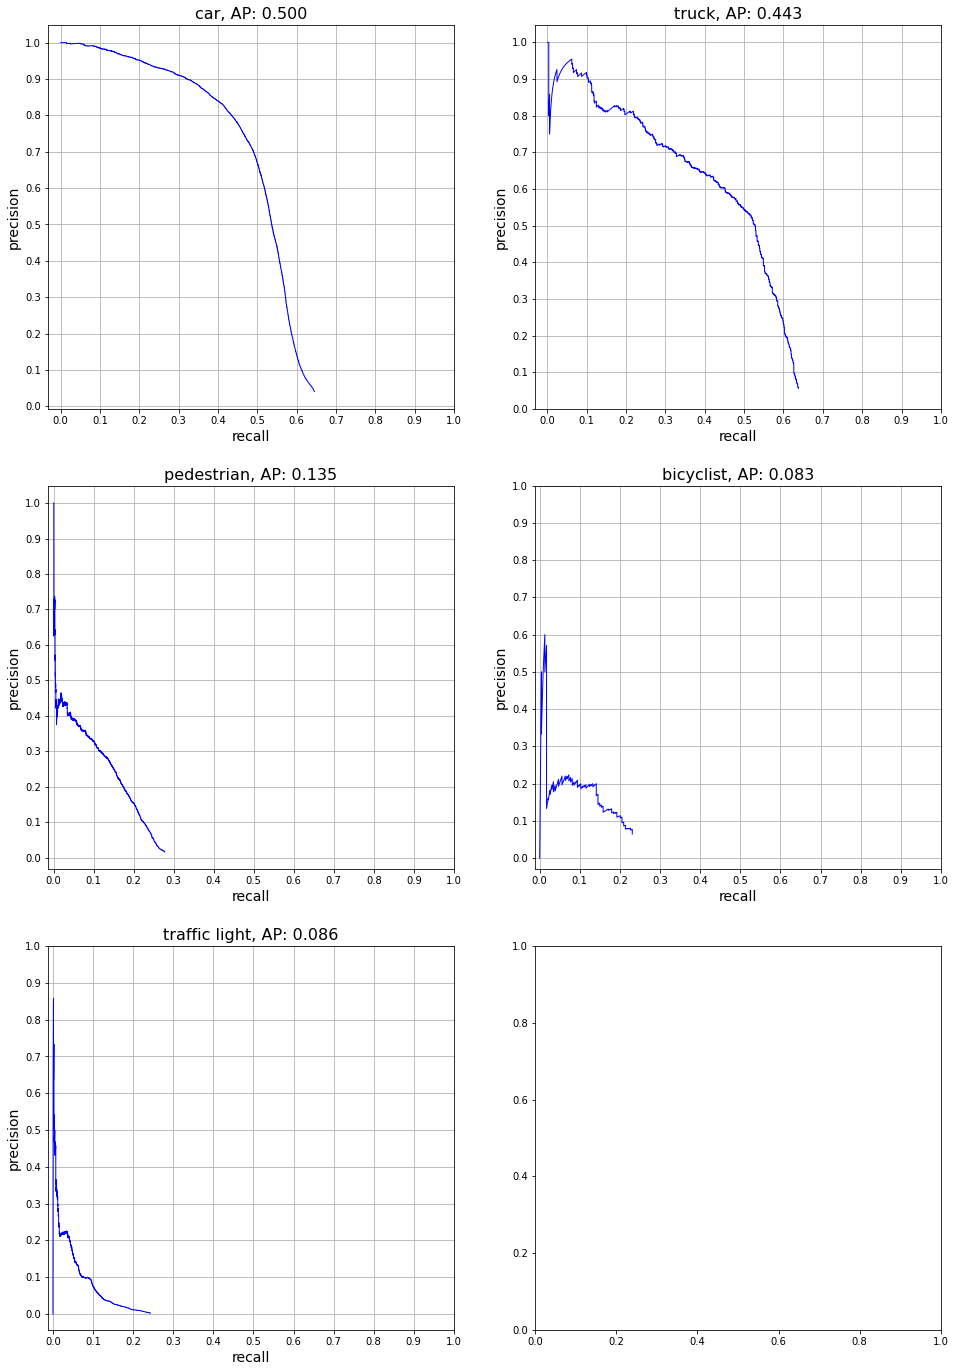

In [ ]:
m = max((n_classes + 1) // 2, 2)
n = 2

fig, cells = plt.subplots(m, n, figsize=(n*8,m*8))
for i in range(m):
    for j in range(n):
        if n*i+j+1 > n_classes: break
        cells[i, j].plot(recalls[n*i+j+1], precisions[n*i+j+1], color='blue', linewidth=1.0)
        cells[i, j].set_xlabel('recall', fontsize=14)
        cells[i, j].set_ylabel('precision', fontsize=14)
        cells[i, j].grid(True)
        cells[i, j].set_xticks(np.linspace(0,1,11))
        cells[i, j].set_yticks(np.linspace(0,1,11))
        cells[i, j].set_title("{}, AP: {:.3f}".format(class_names[n*i+j+1], average_precisions[n*i+j+1]), fontsize=16)

fig.savefig('ssd_evaluation.png')